In [1]:
#basic libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math

# Data processing

Importing data

In [2]:
conversions_df = pd.read_csv("conversions.csv")
impressions_df = pd.read_csv("impressions.csv")

Changing data types

In [3]:
conversions_df.dtypes

user_id             int64
timestamp           int64
conversion_id       int64
conversion_name    object
dtype: object

In [4]:
impressions_df.dtypes

auction_id      int64
timestamp       int64
message_id      int64
user_id         int64
spend         float64
dtype: object

In [5]:
len(conversions_df)

8893

In [6]:
len(impressions_df)

150629

Note that there are some case we have both visite and vente for the same conversion 

In [7]:
conversions_df.loc[conversions_df['user_id'] == 33908]

,user_id,timestamp,conversion_id,conversion_name
39,33908,1531121233,285724,visite
296,33908,1531121762,760041,vente


In [8]:
impressions_df.loc[impressions_df['user_id'] == 99981]

,auction_id,timestamp,message_id,user_id,spend
6571,6599654256913701216,1531131108,651411,99981,0.00035
20271,8065755668993682405,1531124868,335881,99981,0.00026
24866,811021964310957578,1531148883,335881,99981,0.00026
26903,2286291973943522651,1531109084,651411,99981,0.00076
34215,8994645237018204280,1531206302,335881,99981,0.00031
36320,1559426404156853790,1531212878,335881,99981,0.00025
40344,500833133336774120,1531228746,335881,99981,0.00030
45542,7350726697277614471,1531211920,651411,99981,0.00027
67703,4718567649659266075,1531304500,651411,99981,0.00025
80021,1851602215339681834,1531299776,335881,99981,0.00046


Posez vous la question de quel data type appliquer à chaque colonne en fonction des traitements que vous pourrez avoir à faire ensuite

In [9]:
# Exemples de fonctions qui peuvent être utiles
# pd.to_datetime()
conversions_df['timestamp'] = pd.to_datetime(conversions_df['timestamp'],unit='s')
impressions_df['timestamp'] = pd.to_datetime(impressions_df['timestamp'],unit='s')
# On peut ensuite effectuer des opérations de date
impressions_df['timestamp'].min()
# df.astype()


Timestamp('2018-07-09 00:09:28')

Y a-t-il des colonnes que vous pourriez considérer comme "clé primaire" d'une table ? Si oui, y a-t-il l'unicité sur ces colonnes ?

In [10]:
# df.loc[] + df.duplicated()
len(impressions_df.loc[impressions_df.duplicated(subset=['auction_id'])==True])
# nombre de lignes vs. nombre de lignes distinctes...

116

Comment traiteriez-vous les lignes en doublon ?

==> D'abord séparer les ventes et les visites

In [11]:
conversions_visite_df = conversions_df.loc[conversions_df['conversion_name'] == 'visite']
conversions_visite_df = conversions_visite_df.rename(columns={'timestamp' : 'timeof_visit'})
conversions_visite_df = conversions_visite_df.loc[conversions_visite_df.duplicated(subset=['user_id']) == False]
conversions_visite_df = conversions_visite_df.drop('conversion_id', 1)
conversions_visite_df = conversions_visite_df.drop('conversion_name', 1)
conversions_visite_df = conversions_visite_df.groupby(['user_id']).agg(nb_visit = ('timeof_visit','nunique'),
                                                                       timeof_visit = ('timeof_visit','min'))
conversions_visite_df

,nb_visit,timeof_visit
user_id,,
10023,1,2018-07-11 12:52:44
10028,1,2018-07-09 10:43:33
10041,1,2018-07-09 14:23:37
10058,1,2018-07-09 09:42:51
10071,1,2018-07-13 14:53:23
...,...,...
99422,1,2018-07-09 07:42:47
99435,1,2018-07-13 09:10:08
99813,1,2018-07-11 05:08:49


In [12]:
conversions_visite_df = conversions_df.loc[conversions_df['conversion_name'] == 'visite']
conversions_visite_df = conversions_visite_df.groupby(['user_id']).agg(nb_visit = ('timestamp','nunique'),
                                                                       timeof_visit = ('timestamp','min'))
# time of visit is the earliest time that the user has visited the site
conversions_visite_df.loc[conversions_visite_df['nb_visit'] > 1]

,nb_visit,timeof_visit
user_id,,
10684,2,2018-07-09 12:27:05
11433,2,2018-07-09 11:04:34
11444,2,2018-07-10 10:37:29
11930,2,2018-07-12 15:32:01
12017,2,2018-07-12 09:59:44
...,...,...
90772,2,2018-07-12 20:39:51
91789,2,2018-07-09 09:49:38
91874,2,2018-07-09 08:21:21


In [13]:
conversions_vente_df = conversions_df.loc[conversions_df['conversion_name'] == 'vente']
conversions_vente_df = conversions_vente_df.groupby(['user_id']).agg(nb_sale = ('timestamp','nunique'),
                                                                       timeof_sale = ('timestamp','min'))
# time of visit is the earliest time that the user has visited the site
conversions_vente_df

,nb_sale,timeof_sale
user_id,,
10074,2,2018-07-11 19:51:49
10086,1,2018-07-12 12:56:44
10087,1,2018-07-15 03:59:53
10157,1,2018-07-09 13:58:44
10159,1,2018-07-10 09:45:43
...,...,...
98872,1,2018-07-11 10:08:09
98998,1,2018-07-14 05:02:51
99259,1,2018-07-09 08:40:36


In [14]:
#impressions_clean_df = impressions_df.groupby(['user_id','message_id']).agg(spend =("spend","sum"), timeof_impression = ("timestamp","min"))
impressions_clean_df = impressions_df.groupby(['user_id']).agg(nb_messages = ('message_id','nunique'),
                                                               spend =("spend","sum"), timeof_impression = ("timestamp","min"))
#impressions_clean_df = impressions_clean_df.join(conversions_visite_df.set_index('user_id'), on='user_id')
impressions_clean_df = impressions_clean_df.join(conversions_visite_df)
#impressions_clean_df = impressions_clean_df.join(conversions_vente_df.set_index('user_id'), on='user_id')
impressions_clean_df = impressions_clean_df.join(conversions_vente_df)
impressions_clean_df

,nb_messages,spend,timeof_impression,nb_visit,timeof_visit,nb_sale,timeof_sale
user_id,,,,,,,
10000,1,0.00062,2018-07-09 17:48:08,NaN,NaT,NaN,NaT
10001,2,0.00189,2018-07-12 15:05:10,NaN,NaT,NaN,NaT
10002,2,0.00122,2018-07-09 06:29:24,NaN,NaT,NaN,NaT
10004,1,0.00030,2018-07-11 18:09:15,NaN,NaT,NaN,NaT
10005,1,0.00082,2018-07-10 10:57:09,NaN,NaT,NaN,NaT
...,...,...,...,...,...,...,...
99965,1,0.00018,2018-07-11 08:30:13,NaN,NaT,NaN,NaT
99973,1,0.00063,2018-07-10 05:34:09,NaN,NaT,NaN,NaT
99976,1,0.00037,2018-07-10 14:42:51,NaN,NaT,NaN,NaT


# Exercise 1

Q.i The campaign is between

In [15]:
Qi = [impressions_df.timestamp.min(),impressions_df.timestamp.max()]
Qi

[Timestamp('2018-07-09 00:09:28'), Timestamp('2018-07-15 19:05:24')]

Q.ii.	Evaluate campaign performance by differentiating the 2 types of conversions : visits and sales (a table with performance stats is required).

Il faudra ici faire une jointure entre les 2 tables pour pouvoir répondre à la question.
Tips : changer le nom des colonnes de timestamp pour pouvoir différencier et comparer les moments d'impression et de conversion

In [16]:
# Fonctions utiles
# df.rename()
# pd.merge(df1, df2, on=, how = )
# df.loc[]

# fonction custom
def check_conversion(timeof_impression, timeof_conversion):
    if timeof_impression < timeof_conversion:
        return True
    else:
        return False

#df['check_conversion'] = df.apply(lambda x: check_conversion(x['timeof_impression'],x['timeof_conversion']),axis=1)

In [17]:
impressions_clean_df['check_conversion_visit'] = impressions_clean_df.apply(lambda x: 
                                                check_conversion(x['timeof_impression'],x['timeof_visit']),axis=1)
impressions_clean_df['check_conversion_sale'] = impressions_clean_df.apply(lambda x: 
                                                check_conversion(x['timeof_impression'],x['timeof_sale']),axis=1)
impressions_clean_df.loc[impressions_clean_df['check_conversion_visit']].loc[impressions_clean_df['nb_visit'] > 1]

,nb_messages,spend,timeof_impression,nb_visit,timeof_visit,nb_sale,timeof_sale,check_conversion_visit,check_conversion_sale
user_id,,,,,,,,,
11433,1,0.00029,2018-07-09 09:01:07,2.0,2018-07-09 11:04:34,1.0,2018-07-13 17:41:52,True,True
12017,2,0.00082,2018-07-09 16:48:35,2.0,2018-07-12 09:59:44,NaN,NaT,True,False
13912,1,0.00064,2018-07-09 06:24:23,2.0,2018-07-11 10:55:50,NaN,NaT,True,False
17579,1,0.00158,2018-07-10 03:06:14,2.0,2018-07-10 12:03:59,NaN,NaT,True,False
17859,1,0.00047,2018-07-12 17:14:04,2.0,2018-07-13 06:39:04,NaN,NaT,True,False
...,...,...,...,...,...,...,...,...,...
89738,1,0.00052,2018-07-11 10:14:04,2.0,2018-07-11 17:41:02,NaN,NaT,True,False
89759,2,0.00091,2018-07-09 09:15:09,2.0,2018-07-11 20:22:01,NaN,NaT,True,False
89805,1,0.00059,2018-07-10 04:25:16,2.0,2018-07-11 23:33:04,NaN,NaT,True,False


In [18]:
# Overlapping sales and visits
#impressions_clean_df.loc[impressions_clean_df['check_conversion_sale'] & impressions_clean_df['check_conversion_visit']]

In [19]:
def KPI(df):
    # Nombre d’impressions
    nb_impressions = np.array([df.nb_messages.sum(), df.nb_messages.sum()])
    # Cost : Budget dépensé en media
    cost = np.array([df.spend.sum(), df.spend.sum()])
    # CPM : coût pour mille impressions
    CPM = np.array(1000*cost/nb_impressions)
    #Nombre de users uniques imprimés
    nb_users = np.array([len(df), len(df)])
    # Répétition : fréquence moyenne d’impressions par user
    repetition = np.array([df.nb_messages.mean(), df.nb_messages.mean()])
    # Nombre de conversions attribuées, ie. conversions réalisées par les users après impression
    nb_conversions = np.array([df.loc[df['check_conversion_visit']].nb_visit.sum(), 
                               df.loc[df['check_conversion_sale']].nb_sale.sum()])
    # (???) CPA : coût par action, i.e. à combien nous revient chaque conversion attribuée
    CPA = cost/nb_conversions#np.array([0,0])
    
    col = ['Cost', 'CPM','Nb_impressions', 'Nb_impressions_unique','Repetition','Nb_conversions','CPA']
    dat = np.array([cost, CPM, nb_impressions, nb_users, repetition, nb_conversions, CPA])
    
    return pd.DataFrame(dat.T, columns=col, index = ["visit","sale"])

In [20]:
Qii = KPI(impressions_clean_df)
Qii

,Cost,CPM,Nb_impressions,Nb_impressions_unique,Repetition,Nb_conversions,CPA
visit,82.06263,0.711201,115386.0,69238.0,1.666513,3509.0,0.023386
sale,82.06263,0.711201,115386.0,69238.0,1.666513,1604.0,0.051161


Q.iii.	We would like to know the proportion of users id exposed to more than one commercial message. To do this, construct the following table:

In [21]:
# Exemple d'application
#impressions_df.groupby('message_id').agg(nb_impressions =("user_id", "count"), nb_users =("user_id","nunique"))
Qiii = impressions_clean_df.groupby('nb_messages').agg(user_imprime =("spend","count"))
Qiii['part totale'] = Qiii['user_imprime']/len(impressions_clean_df)
Qiii

,user_imprime,part totale
nb_messages,,
1,33643,0.485904
2,26074,0.376585
3,8489,0.122606
4,1032,0.014905


Q.iv.	Finally, the following rule is to be taken into account when allocating conversions:
-	A conversion is considered to be allocated if it takes place less than 1 day after the advertising exposition.
Recalculate the performance of the campaign, taking this rule into account.


In [22]:
# Fonction custom
def check_conversion2(timeof_impression, timeof_convertion):
    if (timeof_impression < timeof_convertion) and (timeof_convertion < timeof_impression +  timedelta(hours=24)):
        return True
    else:
        return False
    
# Voir comment et sur quoi l'appliquer

In [23]:
impressions_clean_allo_df = impressions_clean_df.copy()
impressions_clean_allo_df = impressions_clean_allo_df.drop('check_conversion_visit', 1)
impressions_clean_allo_df = impressions_clean_allo_df.drop('check_conversion_sale', 1)
impressions_clean_allo_df

,nb_messages,spend,timeof_impression,nb_visit,timeof_visit,nb_sale,timeof_sale
user_id,,,,,,,
10000,1,0.00062,2018-07-09 17:48:08,NaN,NaT,NaN,NaT
10001,2,0.00189,2018-07-12 15:05:10,NaN,NaT,NaN,NaT
10002,2,0.00122,2018-07-09 06:29:24,NaN,NaT,NaN,NaT
10004,1,0.00030,2018-07-11 18:09:15,NaN,NaT,NaN,NaT
10005,1,0.00082,2018-07-10 10:57:09,NaN,NaT,NaN,NaT
...,...,...,...,...,...,...,...
99965,1,0.00018,2018-07-11 08:30:13,NaN,NaT,NaN,NaT
99973,1,0.00063,2018-07-10 05:34:09,NaN,NaT,NaN,NaT
99976,1,0.00037,2018-07-10 14:42:51,NaN,NaT,NaN,NaT


In [24]:
impressions_clean_allo_df['check_conversion_visit'] = impressions_clean_df.apply(lambda x: 
                                                check_conversion2(x['timeof_impression'],x['timeof_visit']),axis=1)
impressions_clean_allo_df['check_conversion_sale'] = impressions_clean_df.apply(lambda x: 
                                                check_conversion2(x['timeof_impression'],x['timeof_sale']),axis=1)
impressions_clean_allo_df

,nb_messages,spend,timeof_impression,nb_visit,timeof_visit,nb_sale,timeof_sale,check_conversion_visit,check_conversion_sale
user_id,,,,,,,,,
10000,1,0.00062,2018-07-09 17:48:08,NaN,NaT,NaN,NaT,False,False
10001,2,0.00189,2018-07-12 15:05:10,NaN,NaT,NaN,NaT,False,False
10002,2,0.00122,2018-07-09 06:29:24,NaN,NaT,NaN,NaT,False,False
10004,1,0.00030,2018-07-11 18:09:15,NaN,NaT,NaN,NaT,False,False
10005,1,0.00082,2018-07-10 10:57:09,NaN,NaT,NaN,NaT,False,False
...,...,...,...,...,...,...,...,...,...
99965,1,0.00018,2018-07-11 08:30:13,NaN,NaT,NaN,NaT,False,False
99973,1,0.00063,2018-07-10 05:34:09,NaN,NaT,NaN,NaT,False,False
99976,1,0.00037,2018-07-10 14:42:51,NaN,NaT,NaN,NaT,False,False


In [25]:
Qiv = KPI(impressions_clean_allo_df)
Qiv

,Cost,CPM,Nb_impressions,Nb_impressions_unique,Repetition,Nb_conversions,CPA
visit,82.06263,0.711201,115386.0,69238.0,1.666513,772.0,0.106299
sale,82.06263,0.711201,115386.0,69238.0,1.666513,355.0,0.231162


# Exercise 2

In [26]:
#2 Types of advertising:

#Type 1: promotional offer, corresponding to the messages id "651411" and "530308".
#Type 2: generic offer, corresponding to messages id "335881" and "336028".

#For this exercice let us consider the 2nd hypothesis: 
#conversions must happen up to 1 day before impression

In [27]:
# Fonction custom
def type_of_ad(message_id):
    if message_id == 651411 or  message_id == 530308:
        return "Promotional"
    elif message_id == 335881 or  message_id == 336028:
        return "Generic"

Separate 2 types of impressions data

In [28]:
impressions_adtype_df = impressions_df.copy()
impressions_adtype_df['type_of_ad'] = impressions_adtype_df.apply(lambda x : type_of_ad(x['message_id']),axis=1)
impressions_adtype_df

,auction_id,timestamp,message_id,user_id,spend,type_of_ad
0,1011527229225982812,2018-07-09 07:14:28,335881,81763,0.00048,Generic
1,1019125075080749328,2018-07-09 07:09:24,530308,75065,0.00021,Promotional
2,1026658047695643709,2018-07-09 07:10:52,336028,36559,0.00052,Generic
3,1031386905892227659,2018-07-09 07:30:18,651411,32262,0.00029,Promotional
4,1037113241780132055,2018-07-09 06:58:23,335881,50281,0.00068,Generic
...,...,...,...,...,...,...
150624,8099454765208265847,2018-07-15 19:04:45,336028,48750,0.00061,Generic
150625,8460652359784980519,2018-07-15 19:04:43,336028,52619,0.00029,Generic
150626,8588427627177821422,2018-07-15 19:05:12,336028,79679,0.00056,Generic
150627,8591880332338052557,2018-07-15 19:03:25,336028,78716,0.00010,Generic


In [29]:
impressions_adtypeclean_df = impressions_adtype_df.groupby(['user_id','type_of_ad']).agg(nb_messages = ('message_id','nunique'),
                                                               spend =("spend","sum"), timeof_impression = ("timestamp","min"))
impressions_adtypeclean_df = impressions_adtypeclean_df.join(conversions_visite_df)
impressions_adtypeclean_df = impressions_adtypeclean_df.join(conversions_vente_df)
impressions_adtypeclean_df

nb_messages    spend   timeof_impression  nb_visit  \
user_id type_of_ad                                                        
10000   Generic                1  0.00062 2018-07-09 17:48:08       NaN   
10001   Generic                1  0.00157 2018-07-12 15:05:10       NaN   
        Promotional            1  0.00032 2018-07-15 07:14:50       NaN   
10002   Generic                2  0.00122 2018-07-09 06:29:24       NaN   
10004   Promotional            1  0.00030 2018-07-11 18:09:15       NaN   
...                          ...      ...                 ...       ...   
99973   Generic                1  0.00063 2018-07-10 05:34:09       NaN   
99976   Generic                1  0.00037 2018-07-10 14:42:51       NaN   
99980   Promotional            1  0.00009 2018-07-13 12:12:04       1.0   
99981   Generic                1  0.00211 2018-07-09 08:27:48       NaN   
        Promotional            1  0.00225 2018-07-09 04:04:44       NaN   

                           timeof_visit  nb_sale timeof_sale  
user_id type_of_ad                                            
10000   Generic                     NaT      NaN         NaT  
10001   Generic                     NaT      NaN         NaT  
        Promotional                 NaT      NaN         NaT  
10002   Generic                     NaT      NaN         NaT  
10004   Promotional                 NaT      NaN         NaT  
...                                 ...      ...         ...  
99973   Generic                     NaT      NaN         NaT  
99976   Generic                     NaT      NaN         NaT  
99980   Promotional 2018-07-12 17:07:41      NaN         NaT  
99981   Generic                     NaT      NaN         NaT  
        Promotional                 NaT      NaN         NaT  

[94498 rows x 7 columns]

In [30]:
impressions_adtypeclean_df['check_conversion_visit'] = impressions_adtypeclean_df.apply(lambda x: 
                                                check_conversion2(x['timeof_impression'],x['timeof_visit']),axis=1)
impressions_adtypeclean_df['check_conversion_sale'] = impressions_adtypeclean_df.apply(lambda x: 
                                                check_conversion2(x['timeof_impression'],x['timeof_sale']),axis=1)

In [31]:
impressions_adtypeclean_df

nb_messages    spend   timeof_impression  nb_visit  \
user_id type_of_ad                                                        
10000   Generic                1  0.00062 2018-07-09 17:48:08       NaN   
10001   Generic                1  0.00157 2018-07-12 15:05:10       NaN   
        Promotional            1  0.00032 2018-07-15 07:14:50       NaN   
10002   Generic                2  0.00122 2018-07-09 06:29:24       NaN   
10004   Promotional            1  0.00030 2018-07-11 18:09:15       NaN   
...                          ...      ...                 ...       ...   
99973   Generic                1  0.00063 2018-07-10 05:34:09       NaN   
99976   Generic                1  0.00037 2018-07-10 14:42:51       NaN   
99980   Promotional            1  0.00009 2018-07-13 12:12:04       1.0   
99981   Generic                1  0.00211 2018-07-09 08:27:48       NaN   
        Promotional            1  0.00225 2018-07-09 04:04:44       NaN   

                           timeof_visit  nb_sale timeof_sale  \
user_id type_of_ad                                             
10000   Generic                     NaT      NaN         NaT   
10001   Generic                     NaT      NaN         NaT   
        Promotional                 NaT      NaN         NaT   
10002   Generic                     NaT      NaN         NaT   
10004   Promotional                 NaT      NaN         NaT   
...                                 ...      ...         ...   
99973   Generic                     NaT      NaN         NaT   
99976   Generic                     NaT      NaN         NaT   
99980   Promotional 2018-07-12 17:07:41      NaN         NaT   
99981   Generic                     NaT      NaN         NaT   
        Promotional                 NaT      NaN         NaT   

                     check_conversion_visit  check_conversion_sale  
user_id type_of_ad                                                  
10000   Generic                       False                  False  
10001   Generic                       False                  False  
        Promotional                   False                  False  
10002   Generic                       False                  False  
10004   Promotional                   False                  False  
...                                     ...                    ...  
99973   Generic                       False                  False  
99976   Generic                       False                  False  
99980   Promotional                   False                  False  
99981   Generic                       False                  False  
        Promotional                   False                  False  

[94498 rows x 9 columns]

In [32]:
impressions_adtypeclean_df.loc(axis=0)[:, "Generic"].loc[impressions_adtypeclean_df['check_conversion_visit']]

,,nb_messages,spend,timeof_impression,nb_visit,timeof_visit,nb_sale,timeof_sale,check_conversion_visit,check_conversion_sale
user_id,type_of_ad,,,,,,,,,
10028,Generic,1,0.00122,2018-07-09 04:46:01,1.0,2018-07-09 10:43:33,NaN,NaT,True,False
10071,Generic,1,0.00061,2018-07-13 09:15:04,1.0,2018-07-13 14:53:23,NaN,NaT,True,False
10131,Generic,1,0.00040,2018-07-11 13:39:53,1.0,2018-07-12 10:58:11,NaN,NaT,True,False
10281,Generic,1,0.00076,2018-07-12 13:22:40,1.0,2018-07-13 11:49:09,NaN,NaT,True,False
10314,Generic,2,0.00144,2018-07-10 09:11:22,1.0,2018-07-10 13:16:50,NaN,NaT,True,False
...,...,...,...,...,...,...,...,...,...,...
91447,Generic,2,0.00192,2018-07-09 04:27:15,1.0,2018-07-10 03:36:37,NaN,NaT,True,False
91696,Generic,2,0.00123,2018-07-09 10:57:47,1.0,2018-07-10 09:10:18,1.0,2018-07-10 09:11:58,True,True
91816,Generic,1,0.00056,2018-07-10 06:10:26,1.0,2018-07-10 08:27:21,NaN,NaT,True,False


KPI of generic ads

In [33]:
KPI(impressions_adtypeclean_df.loc(axis=0)[:, "Generic"])

,Cost,CPM,Nb_impressions,Nb_impressions_unique,Repetition,Nb_conversions,CPA
visit,56.14601,0.755717,74295.0,58351.0,1.273243,658.0,0.085328
sale,56.14601,0.755717,74295.0,58351.0,1.273243,292.0,0.192281


KPI of promosional ads

In [34]:
KPI(impressions_adtypeclean_df.loc(axis=0)[:, "Promotional"])

,Cost,CPM,Nb_impressions,Nb_impressions_unique,Repetition,Nb_conversions,CPA
visit,25.91662,0.630713,41091.0,36147.0,1.136775,380.0,0.068202
sale,25.91662,0.630713,41091.0,36147.0,1.136775,188.0,0.137854


# Bonus Exercise

In [35]:
#Dataviz library
import matplotlib.pyplot as plt

#Satistics libraries
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
# Les paramètres de la fonction d'import ne seront pas standards cette fois
forecast_df = pd.read_csv("donnees_prevision_3ans.csv")
forecast_df.dtypes

mois            object
Spend          float64
Conversions      int64
dtype: object

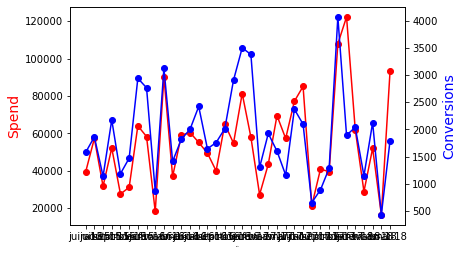

In [37]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(forecast_df["mois"],
        forecast_df["Spend"],
        color="red", 
        marker="o")
# set x-axis label
ax.set_xlabel("Months", fontsize = 0.4)
# set y-axis label
ax.set_ylabel("Spend",
              color="red",
              fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(forecast_df["mois"], forecast_df["Conversions"],color="blue",marker="o")
ax2.set_ylabel("Conversions",color="blue",fontsize=14)
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [38]:
np.corrcoef(forecast_df["Spend"], forecast_df["Conversions"])

array([[1.        , 0.67781126],
       [0.67781126, 1.        ]])

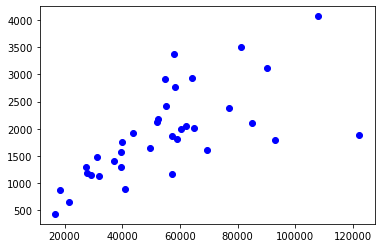

In [39]:
plt.plot(forecast_df["Spend"], forecast_df["Conversions"],'bo')

In [40]:
def time_clean(date):
    if date[:3] == "jan":
        return "01-20" + date[-2:]
    elif date[:3] == "fev":
        return "02-20" + date[-2:]
    elif date[:3] == "mar":
        return "03-20" + date[-2:]
    elif date[:3] == "avr":
        return "04-20" + date[-2:]
    elif date[:3] == "mai":
        return "05-20" + date[-2:]
    elif date[:4] == "juin":
        return "06-20" + date[-2:]
    elif date[:4] == "juil":
        return "07-20" + date[-2:]
    elif date[:3] == "aou":
        return "08-20" + date[-2:]
    elif date[:3] == "sep":
        return "09-20" + date[-2:]
    elif date[:3] == "oct":
        return "10-20" + date[-2:]
    elif date[:3] == "nov":
        return "11-20" + date[-2:]
    elif date[:3] == "dec":
        return "12-20" + date[-2:]

In [41]:
forecast_df["Time"] = pd.to_datetime(forecast_df["mois"].apply(lambda x: time_clean(x)))

In [42]:
forecast_df = forecast_df.drop(columns=['mois'])
forecast_df = forecast_df.set_index('Time')
forecast_df

,Spend,Conversions
Time,,
2015-06-01,39456.23,1578
2015-07-01,57338.93,1864
2015-08-01,31802.36,1138
2015-09-01,52195.88,2176
2015-10-01,27642.56,1185
2015-11-01,31215.60,1471
2015-12-01,64036.93,2942
2016-01-01,58342.15,2768
2016-02-01,18326.47,863


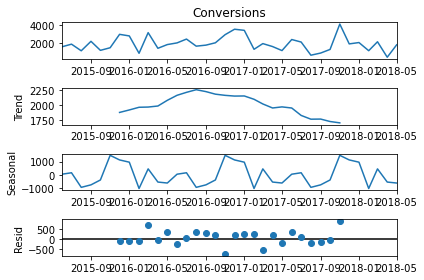

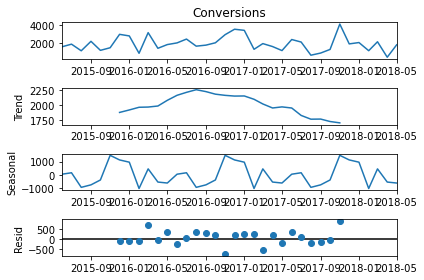

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(forecast_df["Conversions"])
result.plot()

In [44]:
N_train = 30
months = [x.month for x in forecast_df.index]
years = [x.year for x in forecast_df.index]
# convert into one matrix
X_train = np.array([months, years]).T
Y_train = forecast_df["Conversions"]
X_train

array([[   6, 2015],
       [   7, 2015],
       [   8, 2015],
       [   9, 2015],
       [  10, 2015],
       [  11, 2015],
       [  12, 2015],
       [   1, 2016],
       [   2, 2016],
       [   3, 2016],
       [   4, 2016],
       [   5, 2016],
       [   6, 2016],
       [   7, 2016],
       [   8, 2016],
       [   9, 2016],
       [  10, 2016],
       [  11, 2016],
       [  12, 2016],
       [   1, 2017],
       [   2, 2017],
       [   3, 2017],
       [   4, 2017],
       [   5, 2017],
       [   6, 2017],
       [   7, 2017],
       [   8, 2017],
       [   9, 2017],
       [  10, 2017],
       [  11, 2017],
       [  12, 2017],
       [   1, 2018],
       [   2, 2018],
       [   3, 2018],
       [   4, 2018],
       [   5, 2018]])

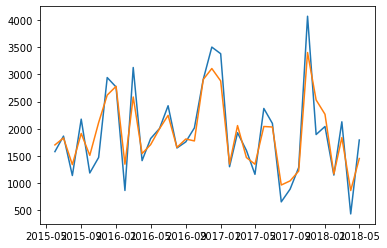

In [45]:
from sklearn.ensemble import RandomForestRegressor
# fit the model
model = RandomForestRegressor()
model.fit(X_train, Y_train)
 
# predict on the same period
preds = model.predict(X_train)
 
# plot what has been learned
plt.plot(forecast_df.index, Y_train)
plt.plot(forecast_df.index, preds)

In [46]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_train, preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_train, preds))

Mean squared error: 94573.91
Coefficient of determination: 0.86


In [47]:
score = model.score(X_train, Y_train)
print("R-squared:", score) 

R-squared: 0.8582393900746712


In [48]:
X_test = np.array([[6,2018],[7,2018]]).T
# predict on the same period
preds = model.predict(X_test)
preds

array([1701.56, 2520.06])